In [81]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape, Add
from keras.metrics import categorical_accuracy
from keras.regularizers import l1_l2, l2, l1
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from tensorflow.python.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

Data import as for the classification model:

In [82]:
from sklearn.model_selection import train_test_split

# Loading the training data
train_df = pd.read_csv('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

# Loading the test data
# test_df = pd.read_csv('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/test/test_set.csv', index_col="Id")
# test_df["img"] = [np.load('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
# test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
# print("The test set contains {} examples.".format(len(test_df)))

#take first 20 columns the values of 0 and 1 of the dataframe as labels
labels_df = train_df.iloc[:, :20]
train_labels = labels_df.values

# Define a function to resize images
def resize_images(img_series, size=(224, 224)):
    return img_series.apply(lambda img: cv2.resize(img, size))

# Resize and convert the images to a numpy array
train_images = np.stack(resize_images(train_df["img"]).values)
#test_images = np.stack(resize_images(test_df["img"]).values)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=0)

# Normalization
print(np.max(X_train))
X_train = X_train / 255
X_val  = X_val / 255
print(np.max(X_train))

The training set contains 749 examples.
255
1.0


Code below copied from Pretrained_classification:

In [83]:
from keras.applications import InceptionResNetV2

base_model = InceptionResNetV2(include_top=False,
                                      weights="imagenet",     # "imagenet" when transfer learning
                                      input_shape=(224, 224, 3),
                                      pooling = "avg"
                                      )
x = base_model.output
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(20, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.load_weights("/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/InceptionResNetV2_augmented.h5")

The code below has been copied (and adapted for size of images and model) from this webpage: https://medium.com/mindboard/generating-adversarial-samples-in-keras-tutorial-f881ac836246

TO DO: Change at least the comments, and maybe some other variable name -> started on models below but not yet finished. will continue once it's working as I want.
& We may want to cite the source? 



Test for one image:

In [41]:
# Function to force pixel values between 0.0 and 1.0
def clip(x):
    return K.clip(x, 0.0, 1.0)

# Function to compute negative Categorical Cross Entropy
# (tested for non-targeted misclassification)
def negative_categorical_crossentropy(yTrue,yPred):
    return 0.0 - K.categorical_crossentropy(yTrue,yPred)

# Add those functions to dictionary
get_custom_objects().update({'clip': Activation(clip)})
get_custom_objects().update({'negative_categorical_crossentropy': negative_categorical_crossentropy})

#function for generating an adversarial example given a base image, adversarial class target, classifier, and regularization type
def generate_adversary(img,target,model,regularization,loss_function):
    
    #input for base image
    image = Input(shape=(224,224,3),name='image')
    #unit input for adversarial noise
    one = Input(shape=(1,),name='unity')

    #layer for learning adversarial noise to apply to image
    noise = Dense(224 * 224 * 3,activation = None,use_bias=False,kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    #reshape noise in shape of image
    noise = Reshape((224, 224, 3),name='reshape')(noise)
    
    #add noise to image
    net = Add(name='add')([noise,image])
    #clip values to be within 0.0 and 1.0
    net = Activation('clip',name='clip_values')(net)
    
    #feed adversarial image to trained MNIST classifier
    outputs = model(net)

    adversarial_model = Model(inputs=[image,one], outputs=outputs)
    #freeze trained MNIST classifier layers
    adversarial_model.layers[-1].trainable = False
    
    adversarial_model.compile(optimizer='sgd', loss=loss_function, metrics=[categorical_accuracy])

    #target adversarial classification
    target_vector = np.zeros(20)
    target_vector[target] = 1.
    
    #callback for saving weights with smallest loss
    checkpoint = ModelCheckpoint('/Users/perrinebamps/Documents/adversarial_weights.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True,
                                 mode='auto', save_freq='epoch')#period=1)
    #train adversarial image
    adversarial_model.fit(x={'image':np.expand_dims(img, axis=0),'unity':np.ones(shape=(1, 1))},y=target_vector.reshape(1,-1),epochs=100,verbose=0,
                         callbacks=[checkpoint])
    #restore best weights
    adversarial_model.load_weights('/Users/perrinebamps/Documents/adversarial_weights.h5')
    
    #quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((224, 224, 3)) * 255.) / 255.
 
    #add trained weights to original image and clip values to produce adversarial image
    adversarial_img = np.clip(img.reshape((224, 224, 3)) + quantized_weights, 0., 1.)
    
    #display adversarial image
    #plt.imshow(adversarial_img,vmin=0., vmax=1.)
    #plt.show()
    #classify adversarial image
    #adversarial_prediction = model.predict(adversarial_img.reshape((1, 224, 224, 3)))
    #ind = adversarial_prediction.argmax()
    #print(labels_df.columns.tolist()[ind])
    
    return adversarial_img, quantized_weights



In [ ]:
# Test with one image:
img = X_train[1]
tgt = y_train[1].argmax()

adv_img = generate_adversary(img,2,model,l1(0.01),'categorical_crossentropy')

Included in a loop so it works for any given image: apply adversarial attack only on class 7 replacing to class 2:

In [78]:
def classify_image(image):
    predictions = model.predict(image.reshape((1, 224, 224, 3)))
    return predictions

def classify_with_adversarial(image):
    # Classify the image
    predictions = classify_image(image)

    # Check if the image is classified as sheep (assuming sheep class is index 5)
    if predictions.argmax() == 7:
        # Generate adversarial example targeting bird class (assuming bird class is index 2)
        adv_img, adv_weights = generate_adversary(image, 2, model, l1(0.01), 'categorical_crossentropy')
        
        # Re-classify the adversarial image
        predictions = classify_image(adv_img)

        return predictions, adv_img, adv_weights
    
    else:
        return predictions, image, np.zeros((224, 224, 3))

Example for an image of the class attacked:

1/1 [==============================] - 0s 325ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 240ms/step


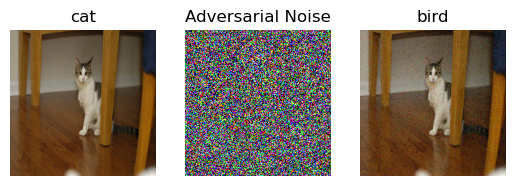

In [79]:
img_true = X_train[3]
ind_true = y_train[3].argmax()
predictions, img_adv, noise_adv = classify_with_adversarial(img_true)
ind_adv = predictions.argmax()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(img_true)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[0].axis('off')
axs[1].imshow(np.clip(noise_adv*100, 0, 1))   # (Noise * 100) to amplify it and improve visibility.
axs[1].set_title("Adversarial Noise")
axs[1].axis('off')
axs[2].imshow(img_adv)
axs[2].set_title(labels_df.columns.tolist()[ind_adv])
axs[2].axis('off')
plt.show()


Example for an image of another class:

1/1 [==============================] - 1s 544ms/step


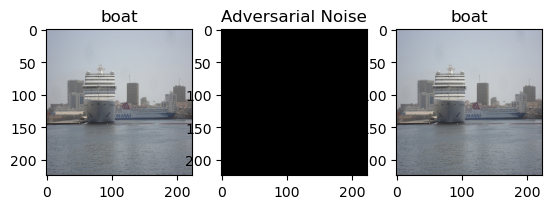

In [80]:
img_true = X_train[2]
ind_true = y_train[2].argmax()
predictions, img_adv, noise_adv = classify_with_adversarial(img_true)
ind_adv = predictions.argmax()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(img_true)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[1].imshow(np.clip(noise_adv*100, 0, 1))   # (Noise * 100) to amplify it and improve visibility & clip to color range.
axs[1].set_title("Adversarial Noise")
axs[2].imshow(img_adv)
axs[2].set_title(labels_df.columns.tolist()[ind_adv])
plt.show()

The adversarial attack has been implemented following a tutorial by Eric Muccino on Medium.com. The idea is to create a model that is identical to our best trained classification models with an additional adversarial block. This block will create adversarial noise which when added to the input data will confuse the classification model. 

In practice, the block is composed of an adversarial layer which is a dense layer of as many neurons as pixel in the input images fully connected to a single neuron of constant value 1 (Unity layer). This means that each neuron of this adversarial layer represents the weight that will be applied to each single pixel. The outputs of the adversarial layer, called the adversarial noises, are reschaped and then added to the input images in such a way that the input images visually look unchanged but that will impact the classification task.

The training works using the categorical cross entropy loss function, to which we give the "false" class that we want to attribuate. We have trained our adversarial model on cat pictures with the target classification being bird. Of course, only the new layers of the model were trained. All layers from our initial model were frozen. Additionally, regularization, we have picked l1, has been applied to keep the pixel pertubation small (and so unseen).

Here is a summary of the model:

In [ ]:
#adversarial_model.summary()

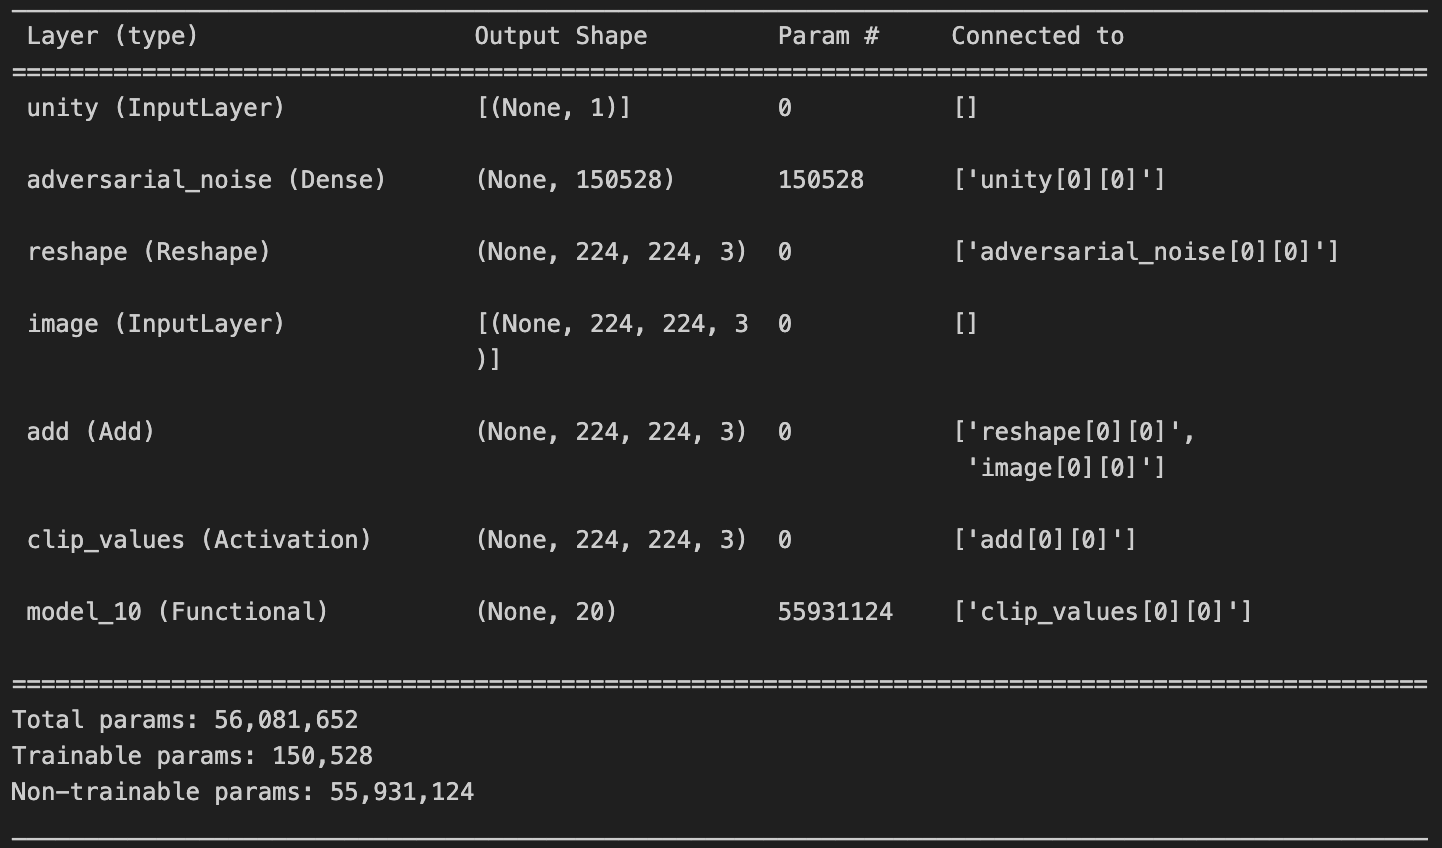

This is the test when I train the model with all images of cat, with the goal of having one adversarial mask that would work for all. Trained for one hour, but didn't misclassify the cats afterwards. -> Still to be investigated why. 
If I'm not confusing models, I think the test I did with two image of cats was working well.. Maybe need more epochs?

In [179]:
im_size = 224
im_depth = 3

# Function to force pixel values between 0.0 and 1.0
def clip(x):
    return K.clip(x, 0.0, 1.0)

# Add this function to dictionary
get_custom_objects().update({'clip': Activation(clip)})

# Training a model to create an adversarial pertubation for a batch of images
def train_adversary_model_for_batch(batch_images, target_class, model, regularization, loss_function, epochs=100):
    image = Input(shape=(im_size, im_size, im_depth), name='image')
    one = Input(shape=(1,), name='unity')
    
    # Adversarial layer
    noise = Dense(im_size * im_size * im_depth, activation=None, use_bias=False, kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    noise = Reshape((im_size, im_size, im_depth), name='reshape')(noise)
    
    # Add noise to images & Clip pixels to [0,1]
    net = Add(name='add')([noise, image])
    net = Activation('clip', name='clip_values')(net)
    
    # Feed adversarial images to our (best) trained classifier
    outputs = model(net)

    # Adversarial model
    adversarial_model = Model(inputs=[image, one], outputs=outputs)
    
    # Freeze layers of our trained classifier
    adversarial_model.layers[-1].trainable = False
    
    # Compile adversarial model (with SGD optimizer and categorical accuracy for the metric)
    adversarial_model.compile(optimizer='sgd', loss=loss_function, metrics=[categorical_accuracy])
        
    # Target adversarial classification
    target_vector = np.zeros((len(batch_images), 20))
    target_vector[:, target_class] = 1.
    
    # Callback for saving weights with smallest loss
    checkpoint = ModelCheckpoint('/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/adversarial_weights.h5', monitor='loss', verbose=0, 
                                 save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
    
    # Expand dimensions of images to include batch size
    array_batch = np.array(batch_images)
    one_batch = np.ones((len(batch_images), 1))
    
    # Train adversarial model
    adversarial_model.fit(x={'image': array_batch, 'unity': one_batch}, y=target_vector, epochs=epochs, verbose=0,
                         callbacks=[checkpoint])
    
    # Restore best weights
    adversarial_model.load_weights('/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/adversarial_weights.h5')
    
    # Quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((224, 224, 3)) * 255.) / 255.
    
    # Save adversarial noise weights
    np.save('/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/generalized_adversarial_noise.npy', quantized_weights)
    
    return quantized_weights

# Subselect all images of Cats & Force classification to be Bird:
batch_images = X_train[np.argmax(y_train, axis=1)==7]   # 7 = Cat
target = 2  # 2 = Bird
# Train the adversarial model with l1 regularization and categorical crossentropy loss as the loss function
adversarial_noise = train_adversary_model_for_batch(batch_images, target, model, l1(0.01), 'categorical_crossentropy', epochs=100)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#LOAD last saved

im_size = 224
im_depth = 3

# Function to force pixel values between 0.0 and 1.0
def clip(x):
    return K.clip(x, 0.0, 1.0)

# Add this function to dictionary
get_custom_objects().update({'clip': Activation(clip)})


image = Input(shape=(im_size, im_size, im_depth), name='image')
one = Input(shape=(1,), name='unity')
 # Adversarial layer
noise = Dense(im_size * im_size * im_depth, activation=None, use_bias=False, kernel_initializer='random_normal',kernel_regularizer=l1(0.01), name='adversarial_noise')(one)
    
noise = Reshape((im_size, im_size, im_depth), name='reshape')(noise)

# Add noise to images & Clip pixels to [0,1]
net = Add(name='add')([noise, image])
net = Activation('clip', name='clip_values')(net)
# Feed adversarial images to our (best) trained classifier
outputs = model(net)

 # Adversarial model
adversarial_model = Model(inputs=[image, one], outputs=outputs)
    
# Freeze layers of our trained classifier
adversarial_model.layers[-1].trainable = False
    
# Compile adversarial model (with SGD optimizer and categorical accuracy for the metric)
adversarial_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[categorical_accuracy])
        
 
# Restore best weights
adversarial_model.load_weights('adversarial_weights.h5')

# Subselect all images of Cats & Force classification to be Bird:
batch_images = X_train[np.argmax(y_train, axis=1)==7]   # 7 = Cat
target = 2  # 2 = Bird


# Quantize adversarial noise
quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((224, 224, 3)) * 255.) / 255.
    
adversarial_noise = quantized_weights

1/1 [==============================] - 0s 395ms/step


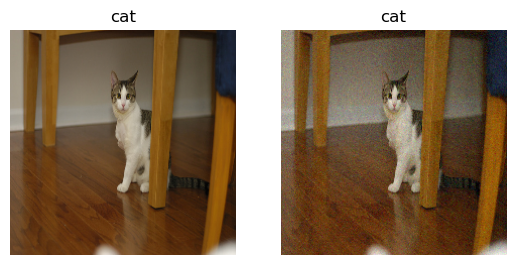

In [193]:
def classify_with_generalized_adversarial(image, model, adversarial_noise):
    # Perform initial classification
    #predictions = model.predict(np.expand_dims(image, axis=0))
    
    # Check if the image is classified as sheep (assuming sheep class is index 5)
    #if predictions.argmax() == 7:
        # Apply pre-trained adversarial noise
    adversarial_img = np.clip(image + adversarial_noise, 0., 1.)
        
        # Re-classify the adversarial image
    predictions = model.predict(np.expand_dims(adversarial_img, axis=0))
    
    return predictions, adversarial_img

# Example usage:
# Load the pre-trained generalized adversarial noise
#adversarial_noise = np.load('generalized_adversarial_noise.npy')

# Classify an image (img)
img = X_train[np.argmax(y_train, axis=1)==7][0,:,:,:]
predictions, adv_img = classify_with_generalized_adversarial(img, model, adversarial_noise)

ind_true = 7
ind_adv = predictions.argmax()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[0].axis('off')

axs[1].imshow(adv_img)
axs[1].set_title(labels_df.columns.tolist()[ind_adv])
axs[1].axis('off')
plt.show()

Test to create an adversarial mask different for each image of cat. It's working well for two cats. I'm currently working on training it for all cats. But this means I have no adversarial mask to apply to non cat image.

In [200]:
def clip(x):
    return K.clip(x, 0.0, 1.0)

# Add custom objects to dictionary
get_custom_objects().update({'clip': Activation(clip)})

def train_adversary_model_for_each_image(sheep_images, target, model, regularization, loss_function, epochs=100):
    adversarial_noises = []

    for i, img in enumerate(sheep_images):
        print(i)
        # Input for base image
        image = Input(shape=(224, 224, 3), name='image')
        # Unit input for adversarial noise
        one = Input(shape=(1,), name='unity')

        # Layer for learning adversarial noise to apply to image
        noise = Dense(224 * 224 * 3, activation=None, use_bias=False, kernel_initializer='random_normal',
                      kernel_regularizer=regularization, name='adversarial_noise')(one)

        # Reshape noise in shape of image
        noise = Reshape((224, 224, 3), name='reshape')(noise)

        # Add noise to image
        net = Add(name='add')([noise, image])
        # Clip values to be within 0.0 and 1.0
        net = Activation('clip', name='clip_values')(net)

        # Feed adversarial image to trained classifier
        outputs = model(net)

        adversarial_model = Model(inputs=[image, one], outputs=outputs)
        # Freeze trained classifier layers
        adversarial_model.layers[-1].trainable = False

        adversarial_model.compile(optimizer='sgd', loss=loss_function, metrics=['categorical_accuracy'])

        # Target adversarial classification
        target_vector = np.zeros((1, 20))
        target_vector[:, target] = 1.

        # Callback for saving weights with smallest loss
        checkpoint = ModelCheckpoint(f'/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/weights/adversarial_weights_{i}.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True,
                                     mode='auto', save_freq='epoch')

        # Expand dimensions of image to include batch size of 1
        sheep_image_batch = np.expand_dims(img, axis=0)
        one_batch = np.ones((1, 1))

        # Train adversarial image
        adversarial_model.fit(x={'image': sheep_image_batch, 'unity': one_batch}, y=target_vector, epochs=epochs, verbose=0,
                             callbacks=[checkpoint])

        # Restore best weights
        adversarial_model.load_weights(f'/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/weights/adversarial_weights_{i}.h5')

        # Quantize adversarial noise
        quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((224, 224, 3)) * 255.) / 255.

        # Save adversarial noise weights
        adversarial_noises.append(quantized_weights)
        np.save(f'/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/weights/adversarial_noise_{i}.npy', quantized_weights)

    return adversarial_noises


In [201]:

sheep_images = X_train[np.argmax(y_train, axis=1)==7][:2,:,:,:]
target = 2
adversarial_noises = train_adversary_model_for_each_image(sheep_images, target, model, l1(0.01), 'categorical_crossentropy')

0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug,

1/1 [==============================] - 1s 506ms/step


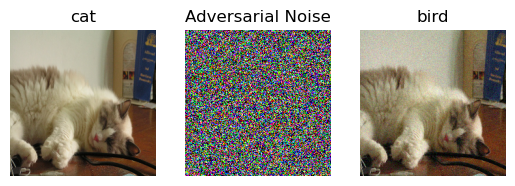

In [214]:
def classify_with_generalized_adversarial(image, model, adversarial_noise):
    # Perform initial classification
    #predictions = model.predict(np.expand_dims(image, axis=0))
    
    # Check if the image is classified as sheep (assuming sheep class is index 5)
    #if predictions.argmax() == 7:
        # Apply pre-trained adversarial noise
    adversarial_img = np.clip(image + adversarial_noise, 0., 1.)
        
        # Re-classify the adversarial image
    predictions = model.predict(np.expand_dims(adversarial_img, axis=0))
    
    return predictions, adversarial_img

# Example usage:
# Load the pre-trained generalized adversarial noise
#adversarial_noise = np.load('generalized_adversarial_noise.npy')

# Classify an image (img)
#for i in range(1)
img = X_train[np.argmax(y_train, axis=1)==7][1]
predictions, adv_img = classify_with_generalized_adversarial(img, model, adversarial_noises[0][1])

ind_true = 7
ind_adv = predictions.argmax()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(img)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[0].axis('off')
axs[1].imshow(clip(adversarial_noises[0][1]*100))
axs[1].set_title("Adversarial Noise")
axs[1].axis('off')
axs[2].imshow(adv_img)
axs[2].set_title(labels_df.columns.tolist()[ind_adv])
axs[2].axis('off')
plt.show()



1/1 [==============================] - 0s 403ms/step


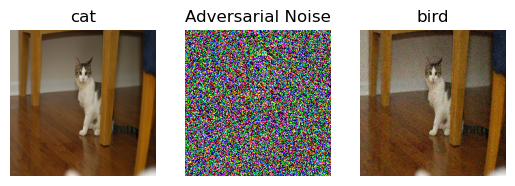

In [216]:
img = X_train[np.argmax(y_train, axis=1)==7][0]
predictions, adv_img = classify_with_generalized_adversarial(img, model, adversarial_noises[0][0])

ind_true = 7
ind_adv = predictions.argmax()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(img)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[0].axis('off')
axs[1].imshow(clip(adversarial_noises[0][0]*100))
axs[1].set_title("Adversarial Noise")
axs[1].axis('off')
axs[2].imshow(adv_img)
axs[2].set_title(labels_df.columns.tolist()[ind_adv])
axs[2].axis('off')
plt.show()

1/1 [==============================] - 0s 473ms/step


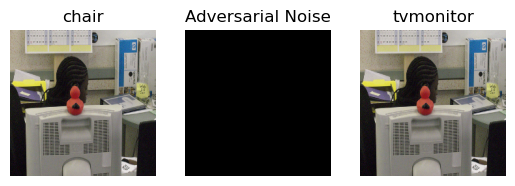

In [218]:
img = X_train[np.argmax(y_train, axis=1)==8][0]
adv_noise=np.zeros_like(img)
predictions, adv_img = classify_with_generalized_adversarial(img, model,adv_noise)

ind_true = 8
ind_adv = predictions.argmax()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(img)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[0].axis('off')
axs[1].imshow(clip(adv_noise))
axs[1].set_title("Adversarial Noise")
axs[1].axis('off')
axs[2].imshow(adv_img)
axs[2].set_title(labels_df.columns.tolist()[ind_adv])
axs[2].axis('off')
plt.show()